# Simulation and parameter recovery of dynamic foraging task.

In [35]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
from aind_behavior_gym.dynamic_foraging.task import CoupledBlockTask
from aind_dynamic_foraging_models.generative_model import ForagerCollection

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get all foragers

In [36]:
forager_collection = ForagerCollection()
df = forager_collection.get_all_foragers()
df.columns

Index(['agent_class_name', 'agent_kwargs', 'agent_alias',
       'number_of_learning_rate', 'number_of_forget_rate', 'choice_kernel',
       'action_selection', 'preset_name', 'n_free_params', 'params', 'forager',
       'win_stay_lose_switch'],
      dtype='object')

In [37]:
df[["agent_class_name", "preset_name", "n_free_params", "params"]]

,agent_class_name,preset_name,n_free_params,params
0,ForagerQLearning,None,3,"$\alpha$, $b_L$, $\beta$"
1,ForagerQLearning,Rescorla-Wagner,3,"$\alpha$, $b_L$, $\epsilon$"
2,ForagerQLearning,None,4,"$\alpha$, $\alpha_{ck}$ (fixed), $w_{ck}$, $b_..."
3,ForagerQLearning,None,4,"$\alpha$, $\alpha_{ck}$ (fixed), $w_{ck}$, $b_..."
4,ForagerQLearning,None,5,"$\alpha$, $\alpha_{ck}$, $w_{ck}$, $b_L$, $\beta$"
5,ForagerQLearning,None,5,"$\alpha$, $\alpha_{ck}$, $w_{ck}$, $b_L$, $\ep..."
6,ForagerQLearning,None,4,"$\alpha$, $\delta$, $b_L$, $\beta$"
7,ForagerQLearning,None,4,"$\alpha$, $\delta$, $b_L$, $\epsilon$"
8,ForagerQLearning,Bari2019,5,"$\alpha$, $\delta$, $\alpha_{ck}$ (fixed), $w_..."
9,ForagerQLearning,None,5,"$\alpha$, $\delta$, $\alpha_{ck}$ (fixed), $w_..."


## Initialize an agent

In [38]:
# Initialize the model
forager = ForagerCollection().get_preset_forager("Hattori2019", seed=42)
forager.set_params(
    softmax_inverse_temperature=5,
    biasL=0,
)

# Create the task environment
task = CoupledBlockTask(reward_baiting=True, num_trials=1000, seed=42)

## Simulation the task

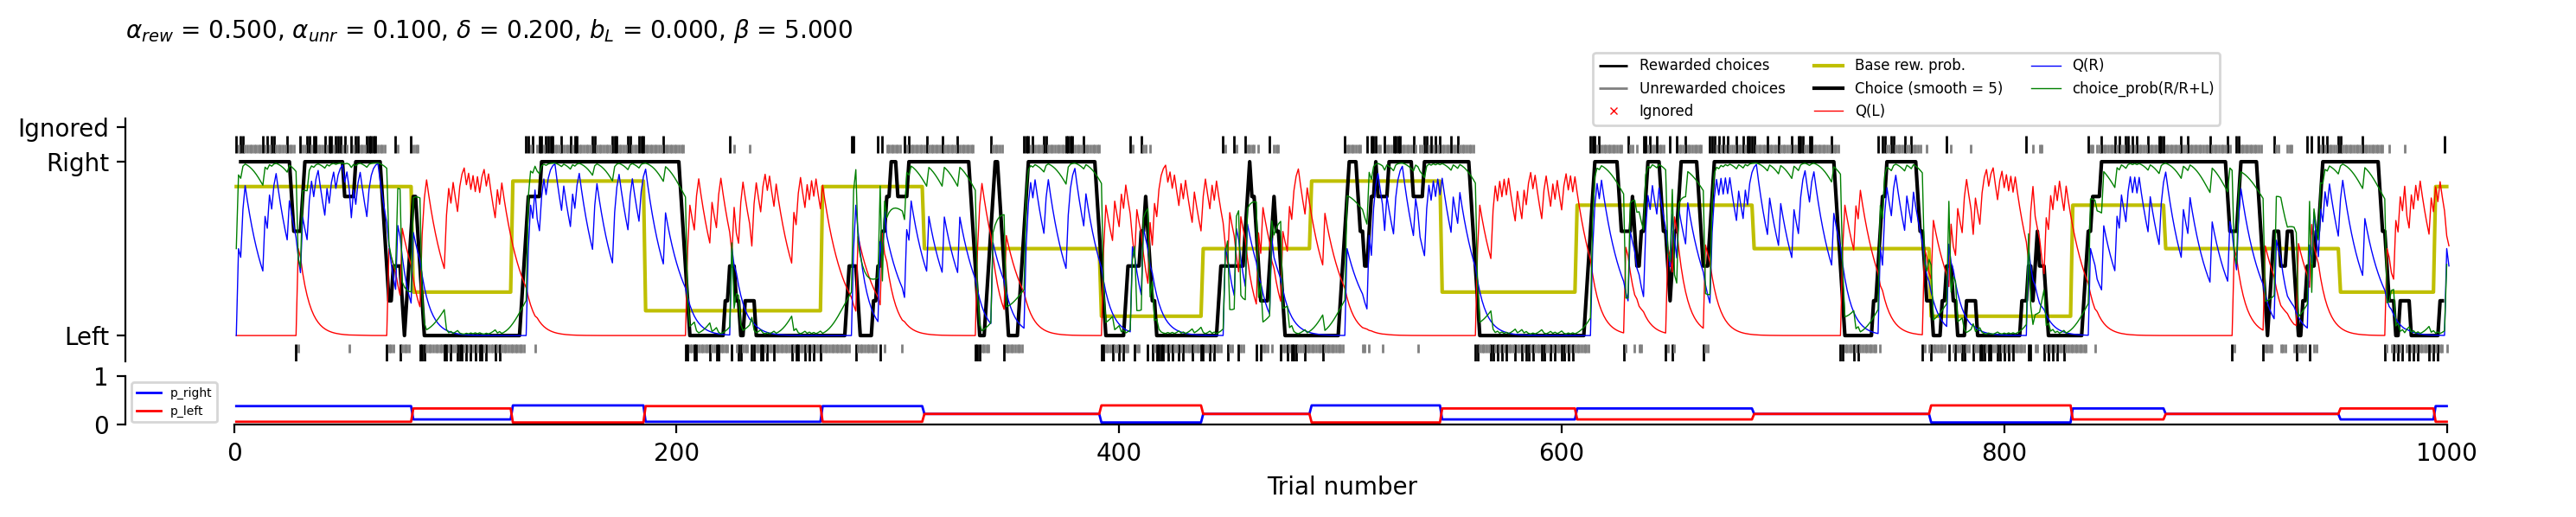

In [39]:
# Run the model
forager.perform(task)

# Capture the results
ground_truth_params = forager.params.model_dump()
ground_truth_choice_prob = forager.choice_prob
ground_truth_q_value = forager.q_value
# Get the history
choice_history = forager.get_choice_history()
reward_history = forager.get_reward_history()

# Plot the session results
fig, axes = forager.plot_session(if_plot_latent=True)

## Parameter Recovery

In [40]:
# Fit the model to recover parameters
forager = ForagerCollection().get_preset_forager("Hattori2019", seed=42)
forager.fit(
    choice_history,
    reward_history,
    fit_bounds_override={"softmax_inverse_temperature": [0, 100]},
    clamp_params={"biasL": 0},
    DE_kwargs=dict(workers=4, disp=True, seed=np.random.default_rng(42)),
    k_fold_cross_validation=2,
)

fitting_result = forager.fitting_result

2025-07-14 12:31:15,945 - aind_dynamic_foraging_models.generative_model.base - INFO - Fitting the model using the whole dataset...
2025-07-14 12:31:15,945 - aind_dynamic_foraging_models.generative_model.base - INFO - Fitting the model using the whole dataset...
2025-07-14 12:31:15,945 - aind_dynamic_foraging_models.generative_model.base - INFO - Fitting the model using the whole dataset...
2025-07-14 12:31:15,945 - aind_dynamic_foraging_models.generative_model.base - INFO - Fitting the model using the whole dataset...
2025-07-14 12:31:15,945 - aind_dynamic_foraging_models.generative_model.base - INFO - Fitting the model using the whole dataset...


differential_evolution step 1: f(x)= 289.0829807952948
differential_evolution step 2: f(x)= 289.0829807952948
differential_evolution step 3: f(x)= 281.81494935346745
differential_evolution step 4: f(x)= 281.81494935346745
differential_evolution step 5: f(x)= 274.5302899183117
differential_evolution step 6: f(x)= 269.50581117373895
differential_evolution step 7: f(x)= 269.50581117373895
differential_evolution step 8: f(x)= 268.8194903533564
differential_evolution step 9: f(x)= 268.8194903533564
differential_evolution step 10: f(x)= 266.7927553904235
differential_evolution step 11: f(x)= 263.6466546216352
differential_evolution step 12: f(x)= 262.19320851442285
differential_evolution step 13: f(x)= 261.2331468139508
differential_evolution step 14: f(x)= 260.82392337795153
differential_evolution step 15: f(x)= 260.82392337795153
differential_evolution step 16: f(x)= 259.7272308092718
differential_evolution step 17: f(x)= 259.7272308092718
differential_evolution step 18: f(x)= 259.72723080

2025-07-14 12:31:29,114 - aind_dynamic_foraging_models.generative_model.base - INFO - Cross-validating the model using 2-fold cross-validation...
2025-07-14 12:31:29,114 - aind_dynamic_foraging_models.generative_model.base - INFO - Cross-validating the model using 2-fold cross-validation...
2025-07-14 12:31:29,114 - aind_dynamic_foraging_models.generative_model.base - INFO - Cross-validating the model using 2-fold cross-validation...
2025-07-14 12:31:29,114 - aind_dynamic_foraging_models.generative_model.base - INFO - Cross-validating the model using 2-fold cross-validation...
2025-07-14 12:31:29,114 - aind_dynamic_foraging_models.generative_model.base - INFO - Cross-validating the model using 2-fold cross-validation...
2025-07-14 12:31:29,115 - aind_dynamic_foraging_models.generative_model.base - INFO - Cross-validation fold 1/2...
2025-07-14 12:31:29,115 - aind_dynamic_foraging_models.generative_model.base - INFO - Cross-validation fold 1/2...
2025-07-14 12:31:29,115 - aind_dynamic_f

differential_evolution step 1: f(x)= 135.31441247407474
differential_evolution step 2: f(x)= 135.31441247407474
differential_evolution step 3: f(x)= 134.11728814996712
differential_evolution step 4: f(x)= 134.11728814996712
differential_evolution step 5: f(x)= 134.11728814996712
differential_evolution step 6: f(x)= 133.65116948610572
differential_evolution step 7: f(x)= 133.65116948610572
differential_evolution step 8: f(x)= 131.5135943487673
differential_evolution step 9: f(x)= 131.5135943487673
differential_evolution step 10: f(x)= 131.5135943487673
differential_evolution step 11: f(x)= 130.79701542268816
differential_evolution step 12: f(x)= 130.79701542268816
differential_evolution step 13: f(x)= 130.79701542268816
differential_evolution step 14: f(x)= 130.5614354968586
differential_evolution step 15: f(x)= 130.5614354968586
differential_evolution step 16: f(x)= 130.4882255741939
differential_evolution step 17: f(x)= 130.4882255741939
differential_evolution step 18: f(x)= 130.48822

2025-07-14 12:31:39,561 - aind_dynamic_foraging_models.generative_model.base - INFO - Cross-validation fold 2/2...
2025-07-14 12:31:39,561 - aind_dynamic_foraging_models.generative_model.base - INFO - Cross-validation fold 2/2...
2025-07-14 12:31:39,561 - aind_dynamic_foraging_models.generative_model.base - INFO - Cross-validation fold 2/2...
2025-07-14 12:31:39,561 - aind_dynamic_foraging_models.generative_model.base - INFO - Cross-validation fold 2/2...
2025-07-14 12:31:39,561 - aind_dynamic_foraging_models.generative_model.base - INFO - Cross-validation fold 2/2...


differential_evolution step 1: f(x)= 135.10124354478836
differential_evolution step 2: f(x)= 133.1199773324392
differential_evolution step 3: f(x)= 133.1199773324392
differential_evolution step 4: f(x)= 131.06476689834454
differential_evolution step 5: f(x)= 131.06476689834454
differential_evolution step 6: f(x)= 131.06476689834454
differential_evolution step 7: f(x)= 129.32398678390223
differential_evolution step 8: f(x)= 128.542556906244
differential_evolution step 9: f(x)= 127.07641721142232
differential_evolution step 10: f(x)= 125.93625659620062
differential_evolution step 11: f(x)= 125.93625659620062
differential_evolution step 12: f(x)= 124.85860970643273
differential_evolution step 13: f(x)= 124.85860970643273
differential_evolution step 14: f(x)= 124.85860970643273
differential_evolution step 15: f(x)= 124.85860970643273
differential_evolution step 16: f(x)= 124.85860970643273
differential_evolution step 17: f(x)= 124.85860970643273
differential_evolution step 18: f(x)= 124.81

In [41]:
# Check fitted parameters
fit_names = fitting_result.fit_settings["fit_names"]
ground_truth = [num for name, num in ground_truth_params.items() if name in fit_names]
print(f"Num of trials: {len(choice_history)}")
print(f"Fitted parameters: {fit_names}")
print(f'Ground truth: {[f"{num:.4f}" for num in ground_truth]}')
print(f'Fitted:       {[f"{num:.4f}" for num in fitting_result.x]}')
print(f"Likelihood-Per-Trial: {fitting_result.LPT}")
print(f"Prediction accuracy full dataset: {fitting_result.prediction_accuracy}\n")

Num of trials: 1000
Fitted parameters: ['learn_rate_rew', 'learn_rate_unrew', 'forget_rate_unchosen', 'softmax_inverse_temperature']
Ground truth: ['0.5000', '0.1000', '0.2000', '5.0000']
Fitted:       ['0.6010', '0.1087', '0.1544', '4.8908']
Likelihood-Per-Trial: 0.7732456884816687
Prediction accuracy full dataset: 0.902



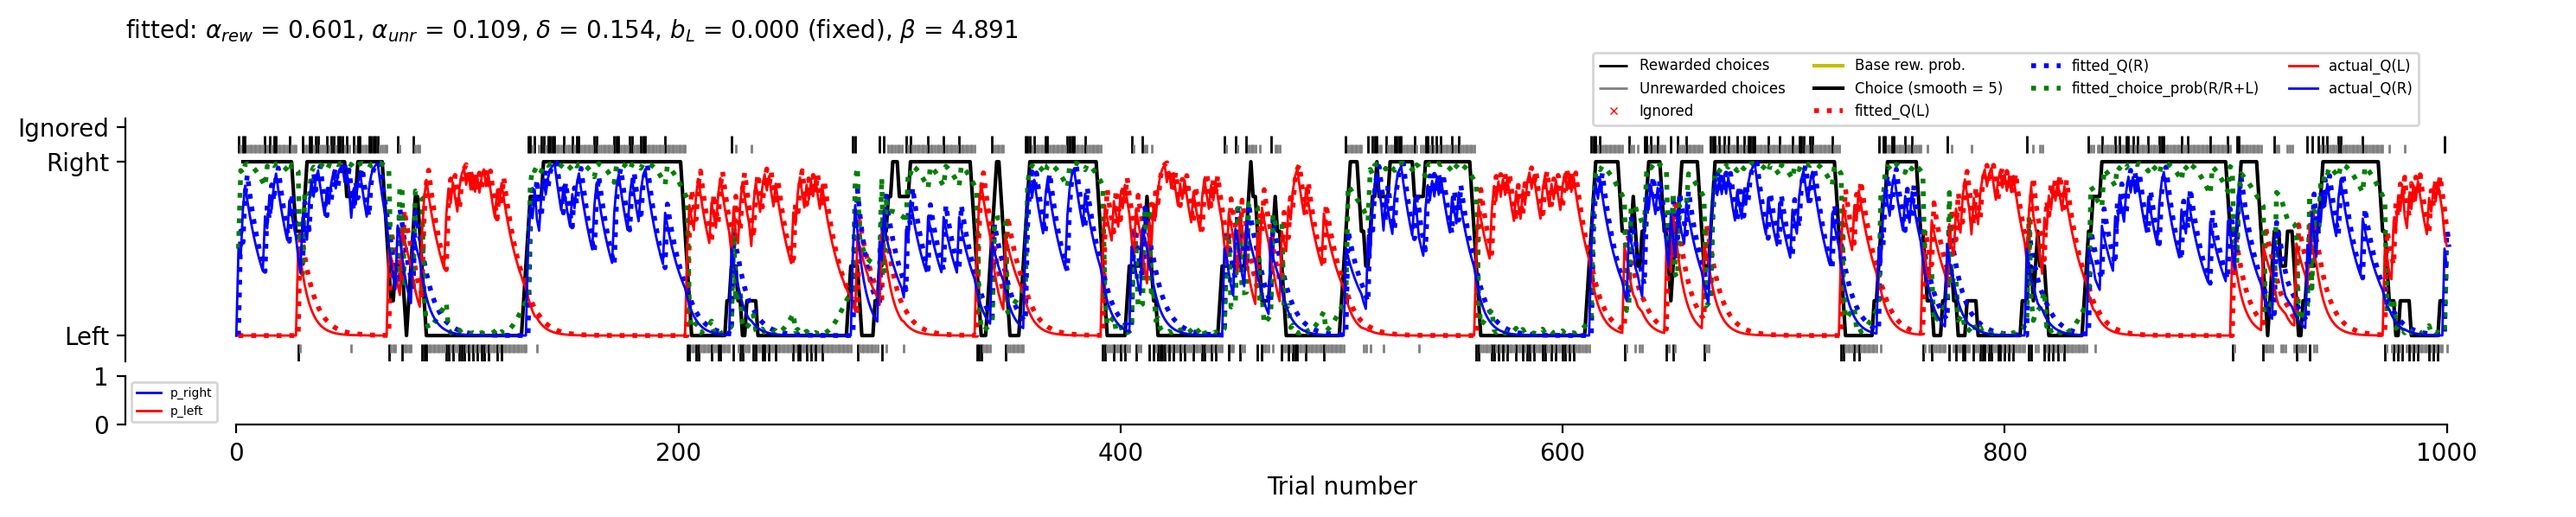

In [42]:
# Plot the fitted session results
fig_fitting, axes = forager.plot_fitted_session(if_plot_latent=True)

# Overlay the ground truth Q-values for comparison
axes[0].plot(ground_truth_q_value[0], lw=1, color="red", ls="-", label="actual_Q(L)")
axes[0].plot(ground_truth_q_value[1], lw=1, color="blue", ls="-", label="actual_Q(R)")
axes[0].legend(fontsize=6, loc="upper left", bbox_to_anchor=(0.6, 1.3), ncol=4)

In [43]:
forager.get_fitting_result_dict().keys()

dict_keys(['fit_settings', 'params', 'log_likelihood', 'AIC', 'BIC', 'LPT', 'LPT_AIC', 'LPT_BIC', 'k_model', 'n_trials', 'nfev', 'nit', 'success', 'population', 'population_energies', 'params_without_polishing', 'log_likelihood_without_polishing', 'prediction_accuracy', 'fitted_latent_variables', 'cross_validation'])

In [44]:
forager.get_fitting_result_dict()["cross_validation"].keys()

dict_keys(['prediction_accuracy_test', 'prediction_accuracy_fit', 'prediction_accuracy_test_bias_only', 'LPT_test', 'LPT_fit', 'fitting_results_each_fold'])